<font size="+2" color="blue">Additional results: various ngram sizes</font>

# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Marcel Fernández Serrano</font>

E-mail: <font color="blue">marcel.fernandez02@estudiant.upf.edu</font>

Date: <font color="blue">15/10/2023</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [2]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [3]:
def jaccard_similarity(l1, l2):
    set1 = set(l1)
    set2 = set(l2)
    jaccard_intersection= len(set1.intersection(set2))    # We want a number of the intersection
    jaccard_union = len(set1.union(set2))                 # The union value (usually greater than insection, except when the two sets are equal then are the same)
    if jaccard_intersection == 0 or jaccard_union == 0:   # Exception case 
        jaccard_similarity = 0 
    else: 
        jaccard_similarity = jaccard_intersection / jaccard_union  # We apply the jaccard similarity formula
    return jaccard_similarity

In [4]:
# Jaccard tests : 
# Example 1
x1=[1,2,3]
y1=[1,2]
print('- First exemple  --> Jaccard coef:',round(jaccard_similarity(x1,y1),3))

# Example 2
x2=[0, 2, 1, 0, 3]
y2=[1, 2, 0, 0, 0]
print('- Second exemple --> Jaccard coef:',jaccard_similarity(x2,y2))
# Example 3
x3=[1,2,3]
y3=[1,2,3]
print('- Third exemple  --> Jaccard coef:',jaccard_similarity(x3,y3))

# Example 4
x4=[] # Empty sets
y4=[]
print('- Fourth exemple --> Jaccard coef:',jaccard_similarity(x4,y4))


- First exemple  --> Jaccard coef: 0.667
- Second exemple --> Jaccard coef: 0.75
- Third exemple  --> Jaccard coef: 1.0
- Fourth exemple --> Jaccard coef: 0


In [5]:
import unicodedata
def clean(text):
    text = re.sub(r'^RT\s+', '', text)  #re.sub(pattern, repl, string, count=0, flags=0)
    
    text = text.lower()     # Converting to lowercase

    text = ''.join([unicodedata.normalize("NFKD", char) for char in text])  # Take care of "ç","ñ","l·l" and all type of accents 'ù','í'...

    # Removing URLs (both http and https)
    text = re.sub(r'https?://\S+', '', text)

    # Removing spaces at the beginning and end
    text = text.strip()

    # Removing anything that is not a letter or digit
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Changing double spaces to single spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [11]:
# Example usage:
dirty_text1 = "RT i love data mining  "
cleaned_text1 = clean(dirty_text1)
print('- First exemple before =  ',dirty_text1)
print('- After clean = ',cleaned_text1)
print()

dirty_text2 = " I LOVE DATA MINING i m'encanta mirar pel·licules  ¨¨¨¨¨¨¨¨"
cleaned_text2 = clean(dirty_text2)
print('- Second exemple before = ', dirty_text2)
print('- After clean = ',cleaned_text2)
print()

dirty_text3 = " ñññññòòóóóóààáá ççç l·l·l "
cleaned_text3 = clean(dirty_text3)
print('- Third exemple before =  ',dirty_text3)
print('- After clean = ',cleaned_text3)
print()

dirty_text4 = " https://www.linkedin.com/in/marcel-fern%C3%A1ndez-serrano follow me in linkedin! "
cleaned_text4 = clean(dirty_text4)
print('- Fourth exemple before =  ',dirty_text4)
print('- After clean = ',cleaned_text4)
print()

dirty_text5 = " Hi          my name ís Jaume "
cleaned_text5 = clean(dirty_text5)
print('- Fifth exemple before = ',dirty_text5)
print('- After clean = ',cleaned_text5)


- First exemple before =   RT i love data mining  
- After clean =  i love data mining

- Second exemple before =   I LOVE DATA MINING i m'encanta mirar pel·licules  ¨¨¨¨¨¨¨¨
- After clean =  i love data mining i mencanta mirar pellicules 

- Third exemple before =    ñññññòòóóóóààáá ççç l·l·l 
- After clean =  nnnnnooooooaaaa ccc lll

- Fourth exemple before =    https://www.linkedin.com/in/marcel-fern%C3%A1ndez-serrano follow me in linkedin! 
- After clean =  follow me in linkedin

- Fifth exemple before =   Hi          my name ís Jaume 
- After clean =  hi my name is jaume


# 2. Implement an n-gram extractor

In [12]:
def remove_short_words(text, min_tokens=2):
    words = text.split()
    filtered_words = []
    for word in words:
        if len(word) >= min_tokens:
            filtered_words.append(word)
    filtered_text = ' '.join(filtered_words)  
    return filtered_text


In [13]:
def ngrams(text, size):
    MIN_TOKEN_LENGTH = 3
    tokens = remove_short_words(clean(text),min_tokens = MIN_TOKEN_LENGTH).split()
    ngrams = []
    for i in range(0,len(tokens)+1-size):
        ngram = ' '.join(tokens[i:i+size])
        ngram_tokens = ngram.split()            
        ngrams.append(ngram)
    return ngrams

In [15]:
# Testing the function
print("We check that it really works well:")
print("_"*140)
print(messages[9780])
print("_"*140)

print("Ngrams: (Shingling)")
print("_"*140)
print(ngrams(messages[9780], 3))
print("_"*140)


We check that it really works well:
____________________________________________________________________________________________________________________________________________
RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
____________________________________________________________________________________________________________________________________________
Ngrams: (Shingling)
____________________________________________________________________________________________________________________________________________
['diariara comerciants xinesos', 'comerciants xinesos donen', 'xinesos donen mascaretes', 'donen mascaretes gel', 'mascaretes gel antiseptic', 'gel antiseptic badalona', 'antiseptic badalona per', 'badalona per lluitar', 'per lluitar contra', 'lluitar contra coronavirus']
_______________________________________________________________________________________________________________

# 3. Estimation for brute force method

In [16]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

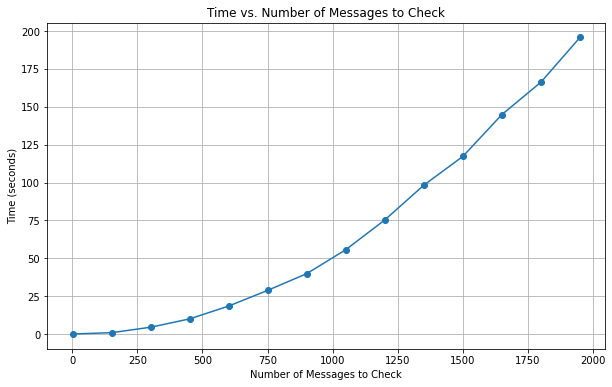

In [40]:
# This plot takes time to plot it
num_messages_to_check = []
processing_times = []
x_values = list(range(1, 2002, 150))

for num_messages in x_values:    
    processing_time = time_brute_force_similarities(messages, num_messages, ngram_size=4)
    num_messages_to_check.append(num_messages)
    processing_times.append(processing_time)

plt.figure(figsize=(10, 6))
plt.plot(num_messages_to_check, processing_times, marker='o')
plt.title("Time vs. Number of Messages to Check")
plt.xlabel("Number of Messages to Check")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

In case that the execution takes long time I leave the output of the code to save your time:

![image.png](attachment:cfa568de-6ad0-426b-b9c6-aeb332d4e417.png)

- If we look at the plot we can see a very important characteristic related to the execution time, it is quadratic/exponencial growth. This means that as the number of messages that we have to check increases, the time it takes to perform this task increases a lot, which is not very good since anything that has an exponential scale as the number of data increases time to inspect increases disproportionately.
- This happens to use a brute force algorithm, these types of algorithms are the least efficient in relation to the computing level because they do all types of verification and this makes the time increasingly longer.
- For the entire input matrix the limit we should pass to the function is 10000, the following code calculates the expected value of time it will take to process the entire matrix, we will see that it's gonna take long time.

In [19]:
def find_quadratic_parameters(point1, point2):
    # Unpack the coordinates of the two points
    x1, y1 = point1
    x2, y2 = point2
    
    # Calculate the coefficients of the quadratic equation
    a = (y1 * x2 - y2 * x1) / ((x1**2) * x2 - (x2**2) * x1)
    b = (y1 - a * (x1**2)) / x1
    c = 0  # Assume c = 0 for your case
    
    # Return the quadratic parameters
    return a, b, c

def expected_value(point1, point2, x):
    a, b, c = find_quadratic_parameters(point1, point2)
    y = a * (x**2) + b * x + c
    return y
time_takes_input_mat = expected_value((x_values[10],processing_times[10]), (x_values[12], processing_times[12]),10000) 

print("Estimated time in hours   --->",round(time_takes_input_mat/3600,3),"h")
print("Estimated time in minutes --->",round(time_takes_input_mat/60,3),"mins")
print("Estimated time in seconds --->",round(time_takes_input_mat,3),"s") 

Estimated time in hours   ---> 1.615 h
Estimated time in minutes ---> 96.881 mins
Estimated time in seconds ---> 5812.859 s


# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [21]:
ngram_size = 4
ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        #if ngram not in ngram_to_index:  --> this is if we dont want to have dupplicated documents
        ngram_to_index[ngram] = next_index
        index_to_ngram[next_index] = ngram
        next_index +=1
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 111347 distinct ngrams in the 10000 documents


In [41]:
# Example ngrams
ngram1 = "govern tancat escoles fins" # We did change because there was an error !!! 4 words to do han example
ngram2 = "aforament per garantir seguretat"

# Find the indices of the example ngrams
index_ngram1 = ngram_to_index.get(ngram1, None)
index_ngram2 = ngram_to_index.get(ngram2, None)

# We take care of the error
if index_ngram1 is not None and index_ngram2 is not None: 
    # Print the indices
    print("Index of '%s': %d" % (ngram1, index_ngram1))
    print("Index of '%s': %d" % (ngram2, index_ngram2))

    # Retrieve the ngrams from the indices
    retrieved_ngram1 = index_to_ngram.get(index_ngram1, None)
    retrieved_ngram2 = index_to_ngram.get(index_ngram2, None)

    if retrieved_ngram1 is not None and retrieved_ngram2 is not None:
        # Print the retrieved ngrams
        print("Ngram for index %d: '%s'" % (index_ngram1, retrieved_ngram1))
        print("Ngram for index %d: '%s'" % (index_ngram2, retrieved_ngram2))
    else:
        print("One or both of the indices do not exist in the index_to_ngram dictionary.")
else:
    print("One or both of the ngrams do not exist in the ngram_to_index dictionary.")

Index of 'govern tancat escoles fins': 41155
Index of 'aforament per garantir seguretat': 46121
Ngram for index 41155: 'govern tancat escoles fins'
Ngram for index 46121: 'aforament per garantir seguretat'


## 2.2 Create table ngrams x documents

In [24]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 111347 rows (distinct shingles) x 10000 columns (distinct documents)


In [25]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram], docid] = True

In [42]:
M_ngram_doc = np.array(M_ngram_doc) # We convert to a numpy array to operate faster

# Count the number of non-zero elements in the matrix
num_non_zero_elements = np.count_nonzero(M_ngram_doc)

# Calculate the total number of cells in the matrix
total_cells = M_ngram_doc.size

# Calculate the density as a percentage
density_percentage = (num_non_zero_elements / total_cells) * 100
print("Density of the M_ngram_doc matrix: %.3f%%" % density_percentage)


Density of the M_ngram_doc matrix: 0.010%


In [46]:
def print_row(row_id):
    message = messages[row_id]
    doc = M_ngram_doc[:, row_id]
    separator_line = "_" * 100  # Use a shorter line for separation

    print(separator_line)
    print("POSITIONS OF NON-ZEROES IN DOCUMENT:")
    positions = [i for i in range(len(doc)) if doc[i]]
    print(positions)

    print(separator_line)
    print("ORIGINAL DOCUMENT:")
    print(message)
    print(separator_line)

    print("CLEAN MESSAGE:")
    cleaned_message = clean(message)
    print(cleaned_message)
    print(separator_line)

    print("NON-ZEROES IN CORRESPONDING ROWS:")
    non_zeroes = [(i, index_to_ngram[i]) for i in range(len(doc)) if doc[i]]
    print(non_zeroes)
    print(separator_line)

In [47]:
# FIRST TEST
print_row(9602)

____________________________________________________________________________________________________
POSITIONS OF NON-ZEROES IN DOCUMENT:
[111289, 111290, 111291, 111292, 111293, 111294, 111295, 111296, 111297]
____________________________________________________________________________________________________
ORIGINAL DOCUMENT:
RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK
____________________________________________________________________________________________________
CLEAN MESSAGE:
emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio
____________________________________________________________________________________________________
NON-ZEROES IN CORRESPONDING ROWS:
[(111289, 'emergenciescat que puc fer'), (111290, 'que puc fer que'), (111291, 'puc fer que faqs'), (111292, 'fer que faqs del'), (111293, 'que faqs del coronavirus'), (111294, 'faqs del cor

In [48]:
# SECOND TEST
print_row(941)

____________________________________________________________________________________________________
POSITIONS OF NON-ZEROES IN DOCUMENT:
[104392, 104403, 104855, 104856, 104857, 105956, 105957, 105958, 109765, 109766, 109767, 109768]
____________________________________________________________________________________________________
ORIGINAL DOCUMENT:
RT @hospiolot: ❕Usem de forma responsable els recursos sanitaris:

📞061➡️ Urgències per #coronavirus i sanitàries

📞012➡️ Consultes general…
____________________________________________________________________________________________________
CLEAN MESSAGE:
hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general
____________________________________________________________________________________________________
NON-ZEROES IN CORRESPONDING ROWS:
[(104392, 'hospiolot usem forma responsable'), (104403, 'sanitaries 012 consultes general'), (104855, 'els recursos sanitaris 061

# 3. Implement a permutation generator

In [49]:
def random_permutation(k):
    permutation = list(range(k))     # We create a list of integers from 0 to k-1
    random.shuffle(permutation)
    return permutation

In [53]:
# Some tests to chech that its going well
k = 10
perm = random_permutation(k)
print('First test ->', perm)
k = 20
perm = random_permutation(k)
print('Second test ->',perm)

First test -> [5, 1, 7, 9, 4, 3, 0, 2, 8, 6]
Second test -> [16, 5, 12, 3, 7, 8, 18, 6, 14, 15, 4, 10, 2, 17, 11, 19, 1, 0, 13, 9]


In [51]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '5 (test5)', '1 (test1)', '4 (test4)', '2 (test2)']
['3 (beta)', '5 (epsilon)', '1 (alpha)', '4 (delta)', '2 (gamma)']

Test another permutation
['5 (test5)', '1 (test1)', '4 (test4)', '2 (test2)', '3 (test3)']
['5 (epsilon)', '1 (alpha)', '4 (delta)', '2 (gamma)', '3 (beta)']


# 4. Compute the signature of each document

In [ ]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 50651, 14088, 29899, ...
Permutation 1: 98513, 77950, 71470, ...
Permutation 2: 70298, 26520, 63351, ...
Permutation 3: 93600, 97563, 10460, ...
Permutation 4: 18911, 51058, 56475, ...


In [31]:
# Initialize the M_signature_doc matrix
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid]:
            return shingle_id
    return -1

# Create signatures for each permutation
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num + 1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # Find the first ngram for the current document and permutation
        first_ngram = find_first_one(docid, permutation)
        if first_ngram != -1:
            M_signature_doc[permutation_num, docid] = first_ngram

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [32]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau
Ngrams        : [107660, 107661, 107662, 107663, 107664, 107665, 107666, 107667, 107668]
Signature     : [107662.0, 107661.0, 107660.0, 107665.0, 107662.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio del coronavirus evitem 

# 5. Compare all pairs of signatures

In [33]:
# Create a dictionary to store possible duplicates
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):
    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:
        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of doc1
        signature1 = extract_signature(docid1)
        
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):
            # If this has not already been marked as a duplicate of another document
            if docid2 not in is_possible_duplicate:
                # Extract signature of doc2
                signature2 = extract_signature(docid2)
                
                # Calculate the similarity between signatures (you need to implement this)
                similarity = jaccard_similarity(signature1, signature2)
                
                # Check if it's a full signature match
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    # Mark docid2 as a possible duplicate of docid1
                    is_possible_duplicate[docid2] = docid1
                # Check if it's a partial signature match
                elif 0.2 < similarity < 1.0:
                    count_sig_partial_matches += 1
                    is_possible_duplicate[docid2] = docid1
                    

        # If the total number of matches (full and partial) exceeds the threshold
        if count_sig_full_matches + count_sig_partial_matches >= 50:
            print("Document %d has at least %d signature matches (Full: %d, Partial: %d)" % (docid1, 50, count_sig_full_matches, count_sig_partial_matches))

# You should implement the `extract_signature` and `calculate_similarity` functions
# according to your specific use case and data.

0/10000 documents scanned
Document 16 has at least 50 signature matches (Full: 71, Partial: 18)
Document 20 has at least 50 signature matches (Full: 28, Partial: 26)
Document 53 has at least 50 signature matches (Full: 57, Partial: 0)
Document 77 has at least 50 signature matches (Full: 6, Partial: 177)
Document 166 has at least 50 signature matches (Full: 56, Partial: 0)
Document 328 has at least 50 signature matches (Full: 65, Partial: 0)
500/10000 documents scanned
1000/10000 documents scanned
2000/10000 documents scanned
3500/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Document 5109 has at least 50 signature matches (Full: 66, Partial: 0)
Document 5117 has at least 50 signature matches (Full: 71, Partial: 0)
Document 5129 has at least 50 signature matches (Full: 54, Partial: 0)
Document 5271 has at least 50 signature matches (Full: 54, Partial: 0)
5500/10000 documents scanned
Document 5636 has at least 50 signature 

In [34]:
print("Original message: \n", messages[5077], ". From document", 5077)
print("Duplicate message: \n", messages[is_possible_duplicate[5077]], ". From document", is_possible_duplicate[5077])

Original message: 
 RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK . From document 5077
Duplicate message: 
 RT @emergenciescat: ✅ Què puc fer i ⛔ què no si estic en una zona afectada pel confinament? 

#ProteccioCivil #Coronavirus https://t.co/lxz… . From document 77


>We observe that the original message and its duplicate are identical. Furthermore, it's evident that this message contains numerous complete matches. This is because, since it originates from @emergenciescat, people replicate or retweet it with the sole intention of spreading awareness about the situation.

In [35]:
print("Original message: \n", messages[84], ". From document", 84)
print("Near duplicate message: \n", messages[is_possible_duplicate[84]], ". From document", is_possible_duplicate[84])

Original message: 
 RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma… . From document 84
Near duplicate message: 
 RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma… . From document 16


>There are many instances of partial matches in this message. One of the potential explanations for this occurrence is that individuals are sharing information from the 'Mossos' about the 'Principat.' Consequently, those who tweet similar messages are paraphrasing the 'Mossos' statements in their own language, which can lead to minor differences in the message.






In [36]:
# --Extra--

# Define the ngram sizes to iterate through
ngram_sizes = [2, 3, 4]

#ngram_sizes = [4]
# Create lists to store the results for each ngram size

full_matches_results = []
partial_matches_results = []
is_possible_duplicate = {}

# Loop over different ngram sizes
for ngram_size in ngram_sizes:
    print("Iteration for ngram =", ngram_size,"...")
    # Reset your data structures and variables here
    ngram_to_index = {}
    index_to_ngram = {}
    next_index = 0
    # Creating dictionary, creating M_ngram_doc, permutations, and M_signature_doc
    for message in messages:
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index +=1
    num_distinct_ngrams = next_index

    # Your existing code for ngram creation, M_ngram_doc, permutations, and signature creation
    M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)
    for docid in range(len(messages)):
        message = messages[docid]
        all_ngrams = ngrams(message, ngram_size)
        for ngram in all_ngrams:
            M_ngram_doc[ngram_to_index[ngram], docid] = True
        # Create a dictionary to store possible duplicates
        #is_possible_duplicate = {}
   
    # Create the permutations
    NUM_PERMUTATIONS = 5
    permutations = []
    for i in range(NUM_PERMUTATIONS):
        permutation = random_permutation(num_distinct_ngrams)
        permutations.append(random_permutation(num_distinct_ngrams))
      
    M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
    
    print("   Scaning permutations...")
    for permutation_num in range(NUM_PERMUTATIONS):
        print("      Creating signatures for permutation %d/%d" % (permutation_num + 1, NUM_PERMUTATIONS))
        permutation = permutations[permutation_num]
        for docid in range(len(messages)):
            first_ngram = find_first_one(docid, permutation)
            if first_ngram != -1:
                M_signature_doc[permutation_num, docid] = first_ngram
    print("   Scan ended!")
    # Iterate through all documents
    
    print("   Comparing documents...")
    
    is_possible_duplicate = {}
    count_sig_full_matches = 0
    count_sig_partial_matches = 0
    for docid1 in range(len(messages)):
        # Do not examine again a document that is a possible duplicate
        if docid1 not in is_possible_duplicate:
            # Counters for full and partial signature matches
            partial_count_sig_full_matches = 0
            partial_count_sig_partial_matches = 0

            # Extract the signature of doc1
            signature1 = extract_signature(docid1)

            # Iterate through documents with docid larger than doc1
            for docid2 in range(docid1 + 1, len(messages)):
                # If this has not already been marked as a duplicate of another document
                if docid2 not in is_possible_duplicate:
                    # Extract signature of doc2
                    signature2 = extract_signature(docid2)

                    # Calculate the similarity between signatures (you need to implement this)
                    similarity = jaccard_similarity(signature1, signature2)

                    # Check if it's a full signature match
                    if similarity == 1.0:
                        partial_count_sig_full_matches += 1
                        # Mark docid2 as a possible duplicate of docid1
                        is_possible_duplicate[docid2] = docid1
                    # Check if it's a partial signature match
                    elif 0.2 < similarity < 1.0:
                        partial_count_sig_partial_matches += 1
        count_sig_full_matches += partial_count_sig_full_matches
        count_sig_partial_matches += partial_count_sig_partial_matches
    full_matches_results.append(count_sig_full_matches)
    partial_matches_results.append(count_sig_partial_matches)
    
    print("   Document comparison ended!")
    # Store the results for the current ngram size


Iteration for ngram = 2 ...
   Scaning permutations...
      Creating signatures for permutation 1/5
      Creating signatures for permutation 2/5
      Creating signatures for permutation 3/5
      Creating signatures for permutation 4/5
      Creating signatures for permutation 5/5
   Scan ended!
   Comparing documents...
   Document comparison ended!
Iteration for ngram = 3 ...
   Scaning permutations...
      Creating signatures for permutation 1/5
      Creating signatures for permutation 2/5
      Creating signatures for permutation 3/5
      Creating signatures for permutation 4/5
      Creating signatures for permutation 5/5
   Scan ended!
   Comparing documents...
   Document comparison ended!
Iteration for ngram = 4 ...
   Scaning permutations...
      Creating signatures for permutation 1/5
      Creating signatures for permutation 2/5
      Creating signatures for permutation 3/5
      Creating signatures for permutation 4/5
      Creating signatures for permutation 5/5
   

In [37]:
print(full_matches_results)

[7383, 7364, 7211]


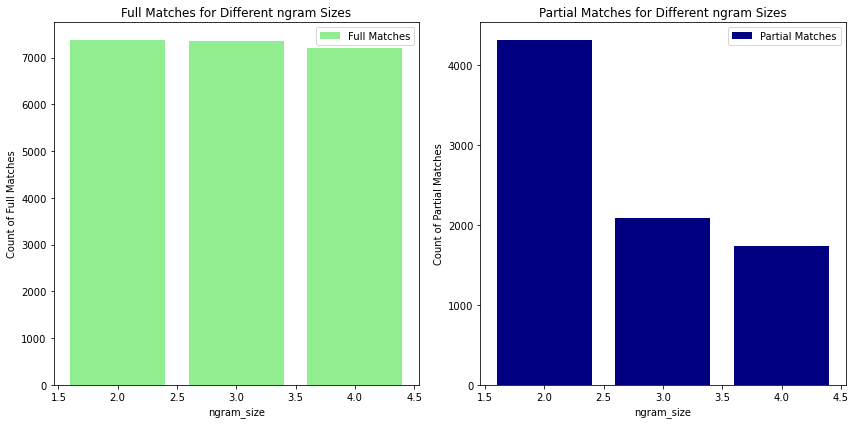

In [58]:
# Define the ngram sizes and their corresponding results
ngram_sizes = [2, 3, 4]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # I do this to have one close to the other

# Create a bar plot for full matches
ax1.bar(ngram_sizes, full_matches_results, color='lightgreen', label='Full Matches')
ax1.set_xlabel('ngram_size')
ax1.set_ylabel('Count of Full Matches')
ax1.set_title('Full Matches for Different ngram Sizes')
ax1.legend()

# Create a bar plot for partial matches
ax2.bar(ngram_sizes, partial_matches_results, color='navy', label='Partial Matches')
ax2.set_xlabel('ngram_size')
ax2.set_ylabel('Count of Partial Matches')
ax2.set_title('Partial Matches for Different ngram Sizes')
ax2.legend()

plt.tight_layout()
plt.show()

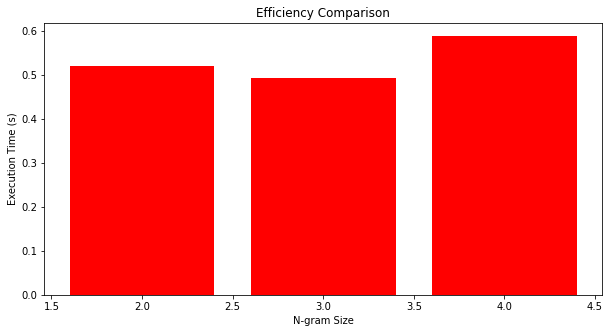

In [60]:
execution_times = []

# Compare 2-grams, 3-grams, and 4-grams
ngram_sizes = [2, 3, 4]
for ngram_size in ngram_sizes:
    # Measure efficiency
    execution_time = time_brute_force_similarities(messages, limit=100, ngram_size=ngram_size)
    execution_times.append(execution_time)

# Create a plot for efficiency
plt.figure(figsize=(10, 5))
plt.bar(ngram_sizes, execution_times, color='red')
plt.xlabel('N-gram Size')
plt.ylabel('Execution Time (s)')
plt.title('Efficiency Comparison')
plt.show()


<font size="+1" color="#003300">We hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>